# Importing Important Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
import torch
import torch.nn as nn
import torch.optim as optim
import random
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.model_selection import train_test_split

# Configuration

In [2]:
# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Generate synthetic imbalanced dataset

In [4]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=1, n_redundant=0, n_repeated=0,
    n_classes=2, weights=[0.95, 0.05],
    n_clusters_per_class=1, random_state=42
)

In [5]:
print("Original class distribution:", Counter(y))

Original class distribution: Counter({np.int64(0): 939, np.int64(1): 61})


# Visualization helper

In [6]:
def plot_resampled(X, y, X_res=None, y_res=None, title="Dataset"):
    plt.figure(figsize=(12, 8))
    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0 (majority)', alpha=0.5)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1 (minority)', alpha=0.8)

    if X_res is not None and y_res is not None:
        mask_new = len(y)  # starting index of new points
        plt.scatter(X_res[mask_new:][y_res[mask_new:]==1, 0],
                    X_res[mask_new:][y_res[mask_new:]==1, 1],
                    c='green', marker='x', label='Synthetic Class 1')

    plt.title(title)
    plt.legend()
    plt.show()

# Plot original dataset

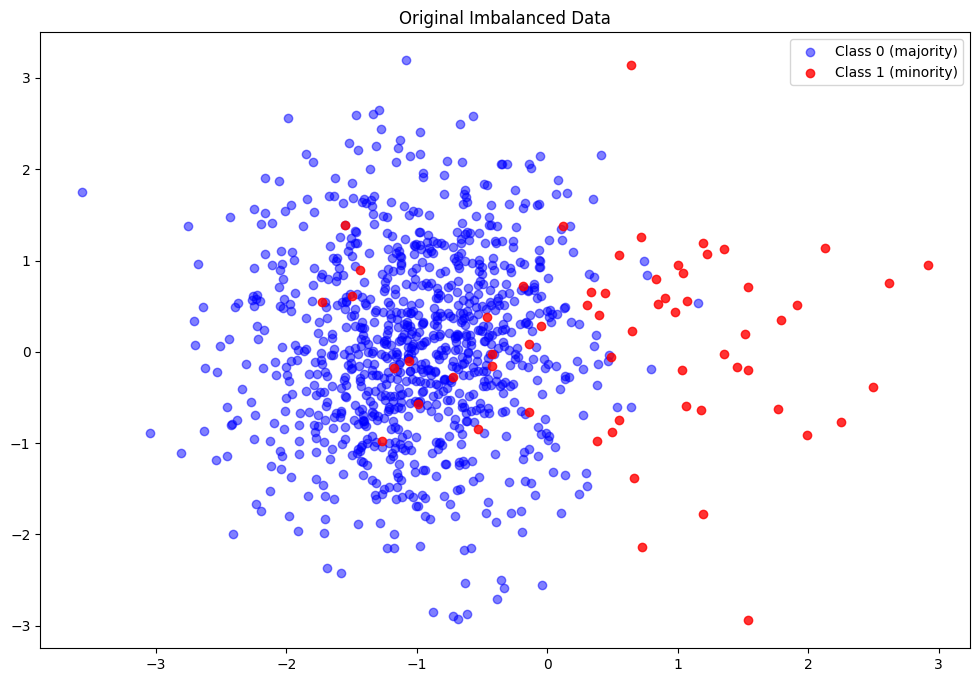

In [7]:
plot_resampled(X, y, title="Original Imbalanced Data")

# Random Oversampling

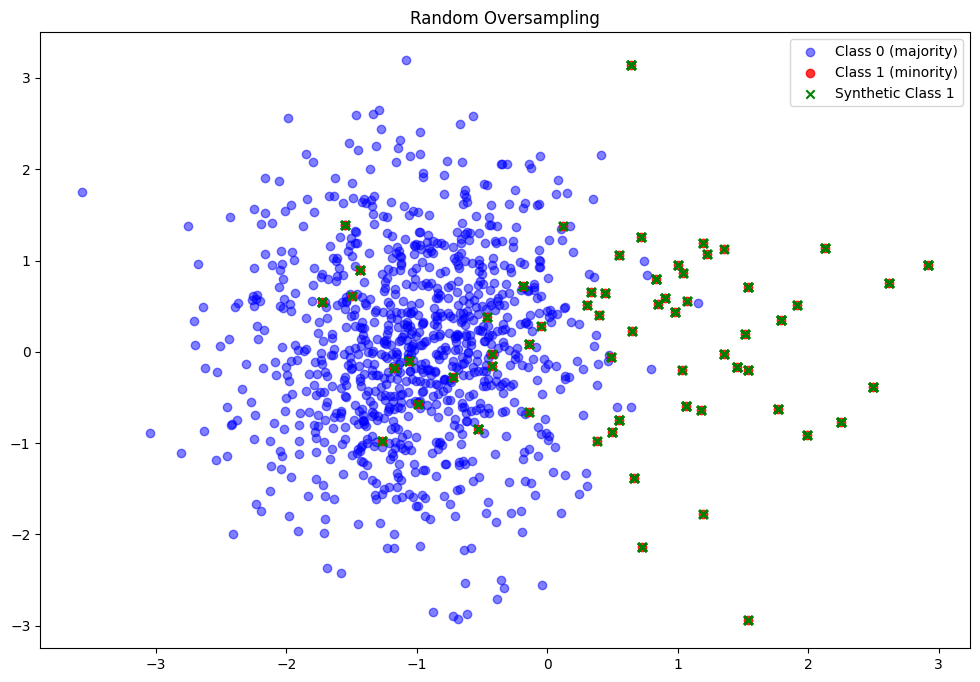

In [8]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
plot_resampled(X, y, X_ros, y_ros, title="Random Oversampling")

# SMOTE

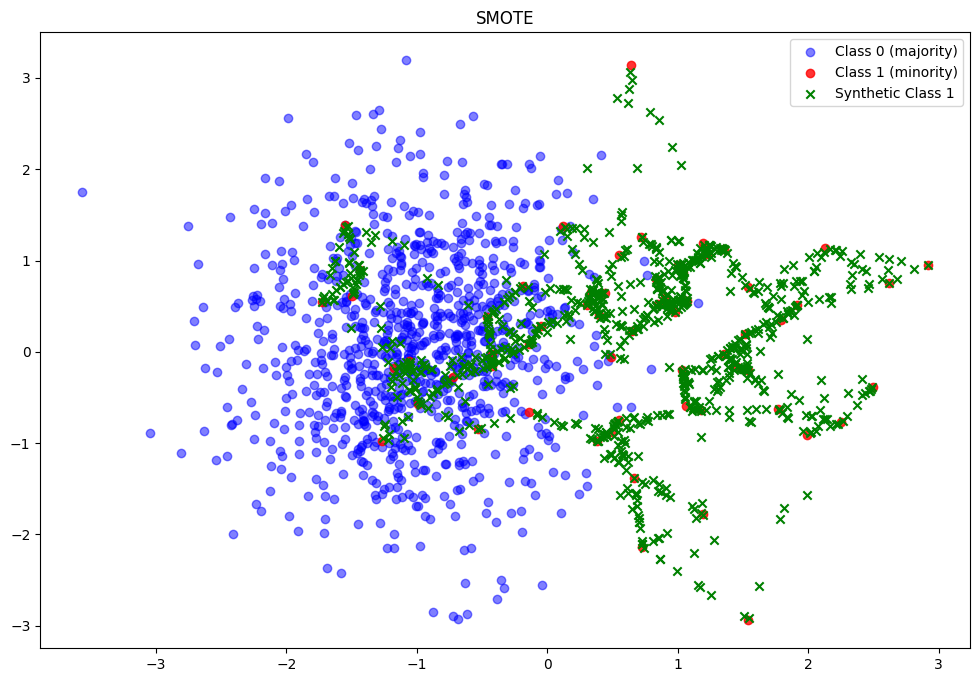

In [9]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
plot_resampled(X, y, X_smote, y_smote, title="SMOTE")

# ADASYN

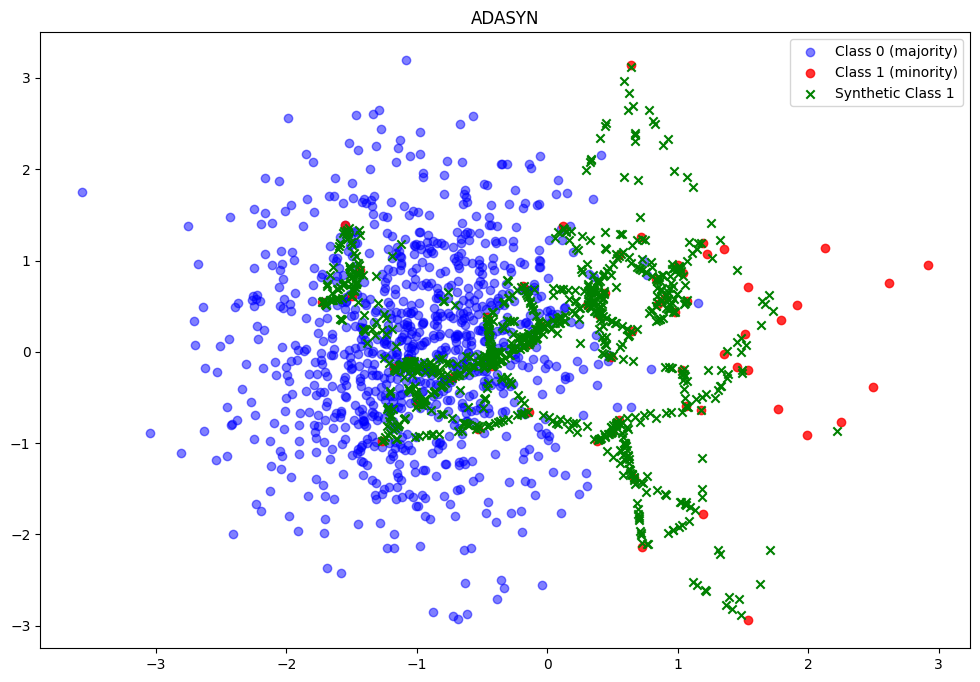

In [10]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
plot_resampled(X, y, X_adasyn, y_adasyn, title="ADASYN")

In [11]:
# Select minority class samples (class 1)
X_minority = X[y == 1]
X_minority = torch.tensor(X_minority, dtype=torch.float32)

# Autoencoder model

Epoch [50/200], Loss: 0.0898
Epoch [100/200], Loss: 0.0083
Epoch [150/200], Loss: 0.0038
Epoch [200/200], Loss: 0.0026


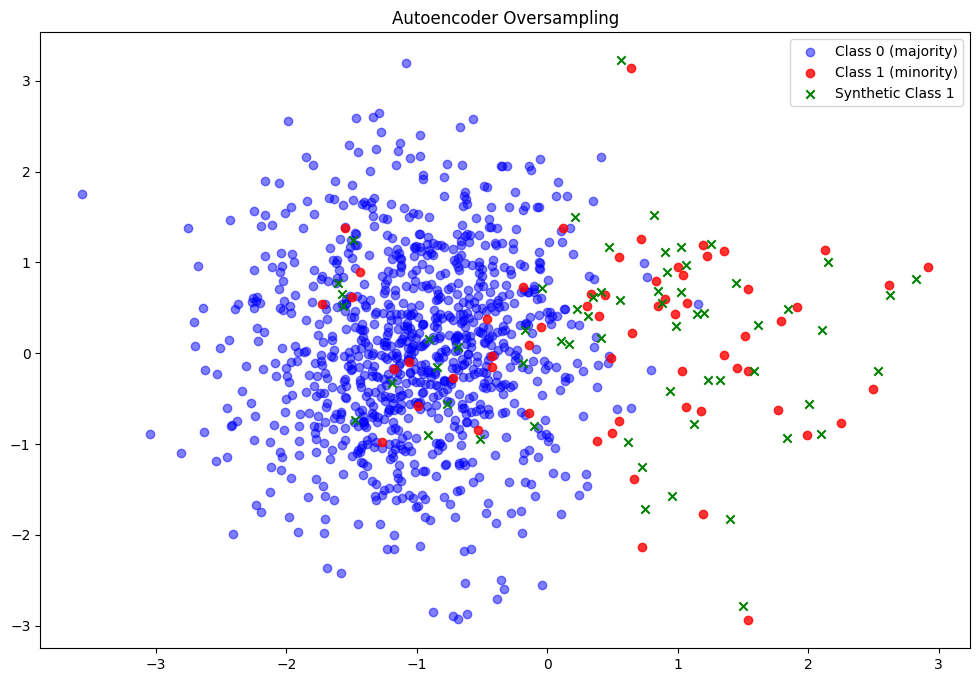

In [12]:
# Select minority class samples (class 1)
X_minority = torch.tensor(X[y == 1], dtype=torch.float32).to(device)

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

# Train Autoencoder
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs, _ = model(X_minority)
    loss = criterion(outputs, X_minority)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Generate synthetic minority samples
with torch.no_grad():
    _, latent = model(X_minority)
    noise = torch.randn_like(latent) * 0.2
    synthetic_latent = latent + noise
    synthetic_samples = model.decoder(synthetic_latent).cpu().numpy()

# Labels for synthetic points
y_synthetic = np.ones(len(synthetic_samples))

# Combine with original data
X_auto = np.vstack([X, synthetic_samples])
y_auto = np.hstack([y, y_synthetic])

# Visualize
plot_resampled(X, y, X_auto, y_auto, title="Autoencoder Oversampling")


# VAE (Variational Autoencoder)

In [13]:
X_minority = X[y == 1].astype(np.float32)
X_minority_t = torch.tensor(X_minority, dtype=torch.float32).to(device)

VAE Epoch 1/150, Loss: 1.259511
VAE Epoch 50/150, Loss: 1.124207
VAE Epoch 100/150, Loss: 0.884586
VAE Epoch 150/150, Loss: 0.645040
VAE synthetic samples generated: 939


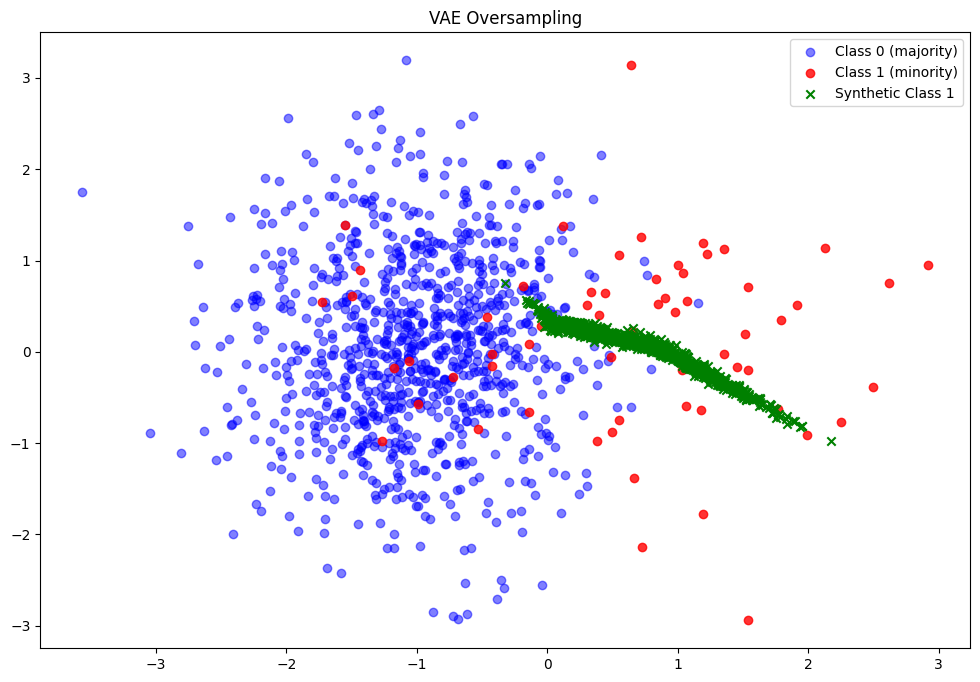

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc_mu = nn.Linear(hidden, latent_dim)
        self.fc_logvar = nn.Linear(hidden, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, hidden)
        self.fc_out = nn.Linear(hidden, input_dim)
        self.relu = nn.ReLU()
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.relu(self.fc_decode(z))
        return self.fc_out(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
def vae_loss(recon, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon, x)
    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld = kld / x.size(0)
    return recon_loss + 1e-3 * kld

# Train VAE on minority class only
epochs = 150
for epoch in range(epochs):
    vae.train()
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_minority_t)
    loss = vae_loss(recon, X_minority_t, mu, logvar)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0 or epoch==0:
        print(f"VAE Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# After training, model the latent distribution of minority class
vae.eval()
with torch.no_grad():
    _, mu_all, logvar_all = vae(X_minority_t)
    mu_np = mu_all.cpu().numpy()

# Fit a Gaussian to the latent vectors (use the means as latent points and compute empirical cov)
latent_means = mu_np  # shape (n_minority, latent_dim)
latent_mean_global = latent_means.mean(axis=0)
latent_cov = np.cov(latent_means.T) + 1e-6 * np.eye(latent_means.shape[1])

# Sample new latent points from this fitted Gaussian
n_to_generate = int(len(y) - np.sum(y))  # balance to majority count
synthetic_latent = np.random.multivariate_normal(latent_mean_global, latent_cov, size=n_to_generate).astype(np.float32)
synthetic_latent_t = torch.tensor(synthetic_latent, dtype=torch.float32).to(device)
with torch.no_grad():
    synthetic_vae = vae.decode(synthetic_latent_t).cpu().numpy()

print("VAE synthetic samples generated:", synthetic_vae.shape[0])

# Combine with original and plot via plot_resampled
y_synth = np.ones(len(synthetic_vae), dtype=int)
X_vae_comb = np.vstack([X, synthetic_vae])
y_vae_comb = np.hstack([y, y_synth])
plot_resampled(X, y, X_vae_comb, y_vae_comb, title="VAE Oversampling")

#  GAN (Simple MLP GAN)

GAN Epoch 1/500, Loss_D: 0.706464, Loss_G: 0.757620
GAN Epoch 100/500, Loss_D: 0.679704, Loss_G: 0.682675
GAN Epoch 200/500, Loss_D: 0.631931, Loss_G: 0.687963
GAN Epoch 300/500, Loss_D: 0.424918, Loss_G: 1.052249
GAN Epoch 400/500, Loss_D: 0.598724, Loss_G: 1.210535
GAN Epoch 500/500, Loss_D: 0.658563, Loss_G: 1.846482
GAN synthetic samples generated: 939


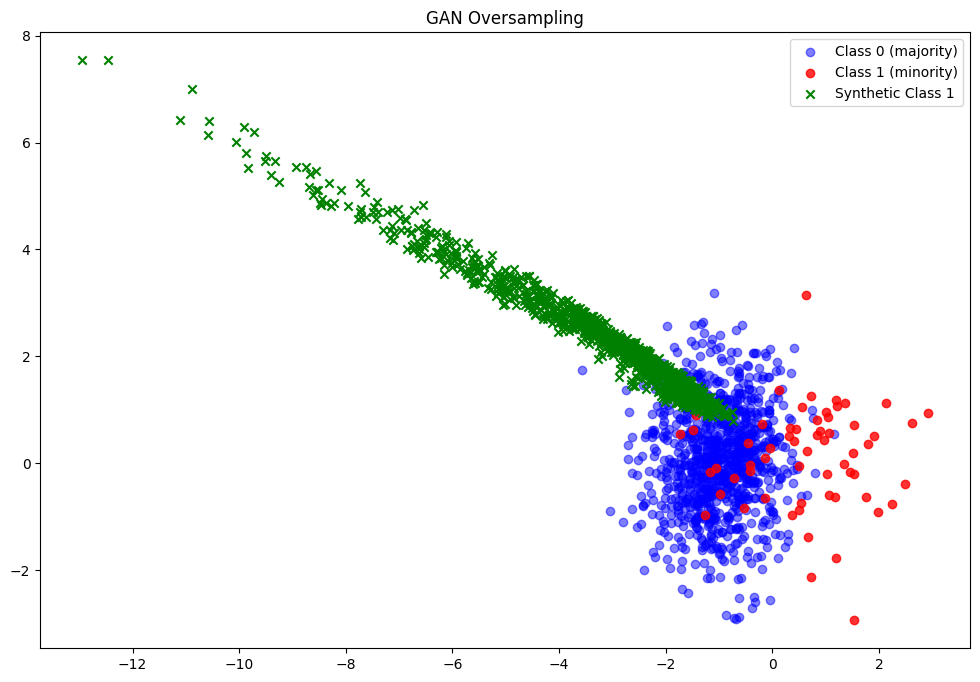

In [15]:
X_minority_t = torch.tensor(X_minority, dtype=torch.float32).to(device)
class Generator(nn.Module):
    def __init__(self, noise_dim=4, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_dim)
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

noise_dim = 4
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)
opt_G = optim.Adam(G.parameters(), lr=1e-3)
opt_D = optim.Adam(D.parameters(), lr=1e-3)
bce = nn.BCELoss()

# Training loop
real_label = 1.
fake_label = 0.
batch_size = 32
n_epochs = 500

# Prepare data loader for minority samples
dataset = torch.utils.data.TensorDataset(X_minority_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(n_epochs):
    for (real_batch,) in loader:
        # Train Discriminator
        D.zero_grad()
        real_data = real_batch.to(device)
        b_size = real_data.size(0)
        labels_real = torch.full((b_size, 1), real_label, dtype=torch.float32).to(device)
        output_real = D(real_data)
        loss_real = bce(output_real, labels_real)

        z = torch.randn(b_size, noise_dim).to(device)
        fake_data = G(z)
        labels_fake = torch.full((b_size, 1), fake_label, dtype=torch.float32).to(device)
        output_fake = D(fake_data.detach())
        loss_fake = bce(output_fake, labels_fake)

        loss_D = (loss_real + loss_fake) * 0.5
        loss_D.backward()
        opt_D.step()

        # Train Generator
        G.zero_grad()
        labels_gen = torch.full((b_size, 1), real_label, dtype=torch.float32).to(device)  # want generator to produce 'real' labels
        output_gen = D(fake_data)
        loss_G = bce(output_gen, labels_gen)
        loss_G.backward()
        opt_G.step()

    if (epoch+1) % 100 == 0 or epoch==0:
        print(f"GAN Epoch {epoch+1}/{n_epochs}, Loss_D: {loss_D.item():.6f}, Loss_G: {loss_G.item():.6f}")

# Generate synthetic samples from trained generator
n_to_generate = int(len(y) - np.sum(y))
with torch.no_grad():
    z = torch.randn(n_to_generate, noise_dim).to(device)
    synthetic_gan = G(z).cpu().numpy()

print("GAN synthetic samples generated:", synthetic_gan.shape[0])

# Combine and plot
y_synth_gan = np.ones(len(synthetic_gan), dtype=int)
X_gan_comb = np.vstack([X, synthetic_gan])
y_gan_comb = np.hstack([y, y_synth_gan])
plot_resampled(X, y, X_gan_comb, y_gan_comb, title="GAN Oversampling")

# Original Dataset

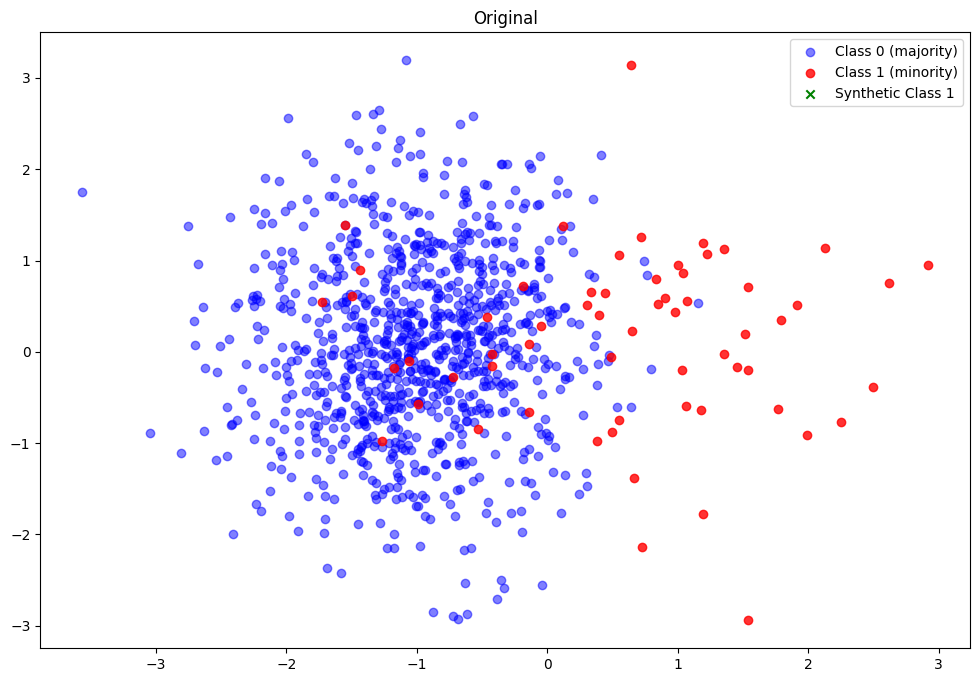

In [16]:
plot_resampled(X, y, X, y, "Original")

# Visualization of Imbalance data handling techniques

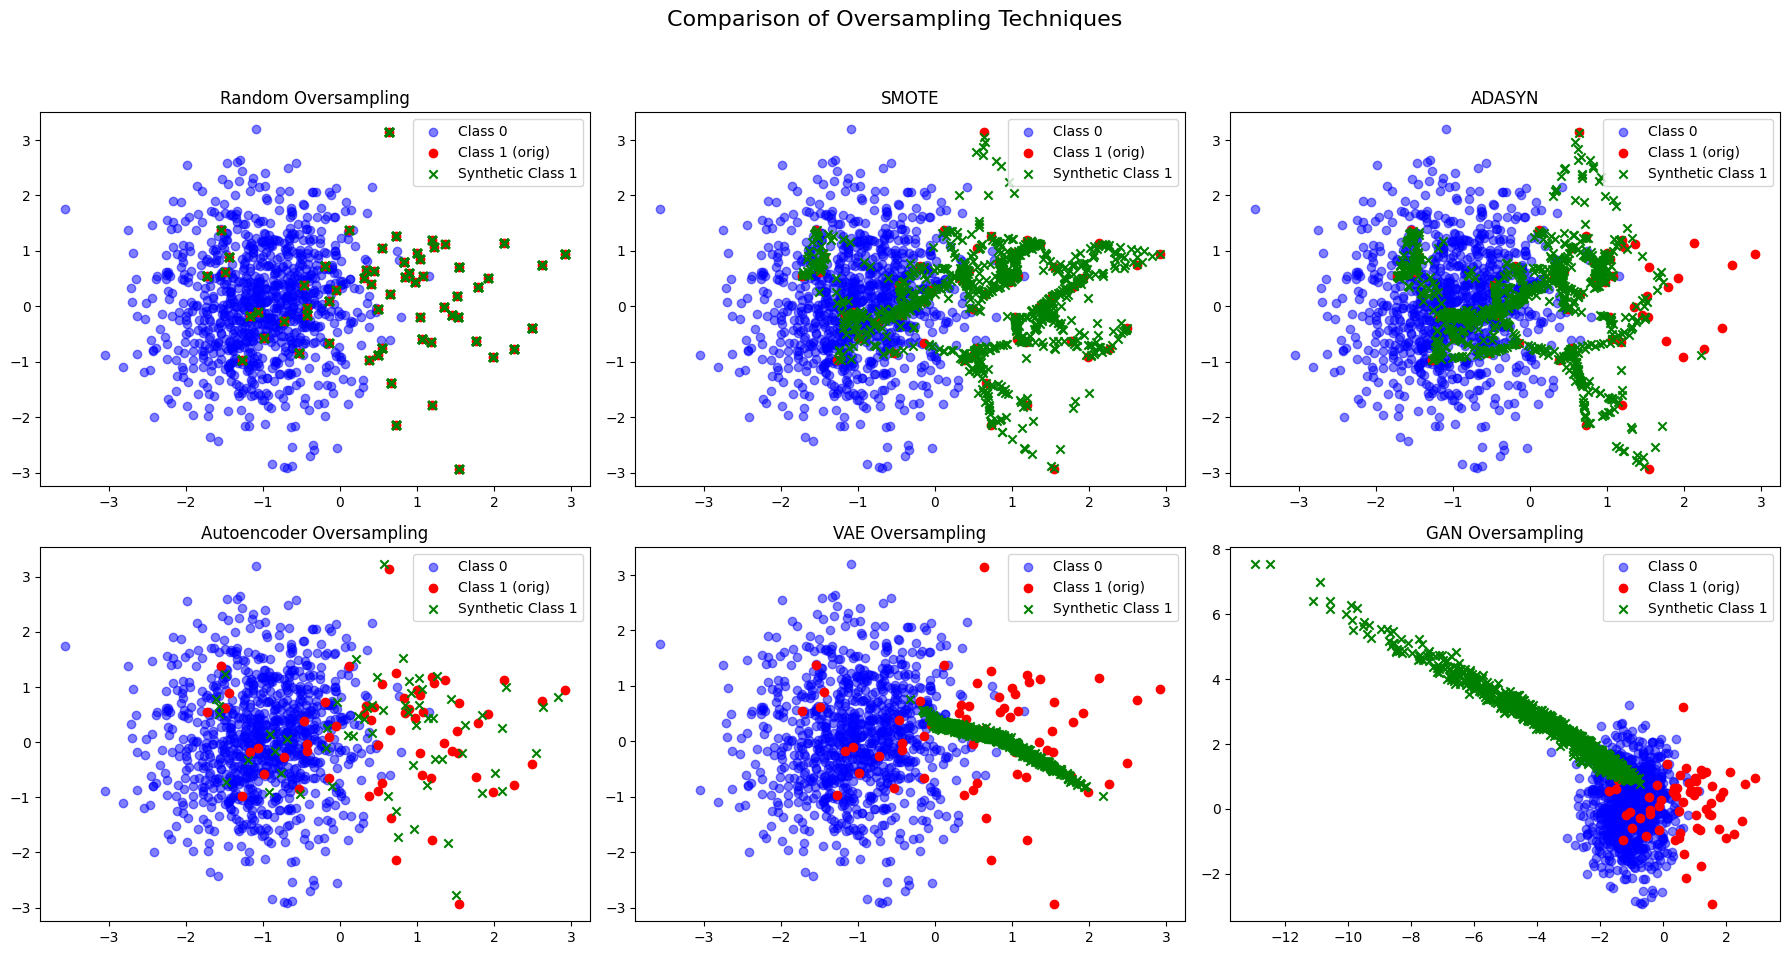

In [17]:
methods = {
    "Random Oversampling": (X_ros, y_ros),
    "SMOTE": (X_smote, y_smote),
    "ADASYN": (X_adasyn, y_adasyn),
    "Autoencoder Oversampling": (X_auto, y_auto),
    "VAE Oversampling": (X_vae_comb, y_vae_comb),
    "GAN Oversampling": (X_gan_comb, y_gan_comb)
}

# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

mask_new = len(y)  # starting index of synthetic points

# Loop through methods and plot
for ax, (title, (X_res, y_res)) in zip(axes.ravel(), methods.items()):
    # Original data
    ax.scatter(X[y==0,0], X[y==0,1], c='blue', alpha=0.5, label='Class 0')
    ax.scatter(X[y==1,0], X[y==1,1], c='red', label='Class 1 (orig)')

    # Synthetic points (class 1 only)
    ax.scatter(
        X_res[mask_new:][y_res[mask_new:]==1,0],
        X_res[mask_new:][y_res[mask_new:]==1,1],
        c='green', marker='x', label='Synthetic Class 1'
    )

    ax.set_title(title)
    ax.legend()

plt.suptitle("Comparison of Oversampling Techniques", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


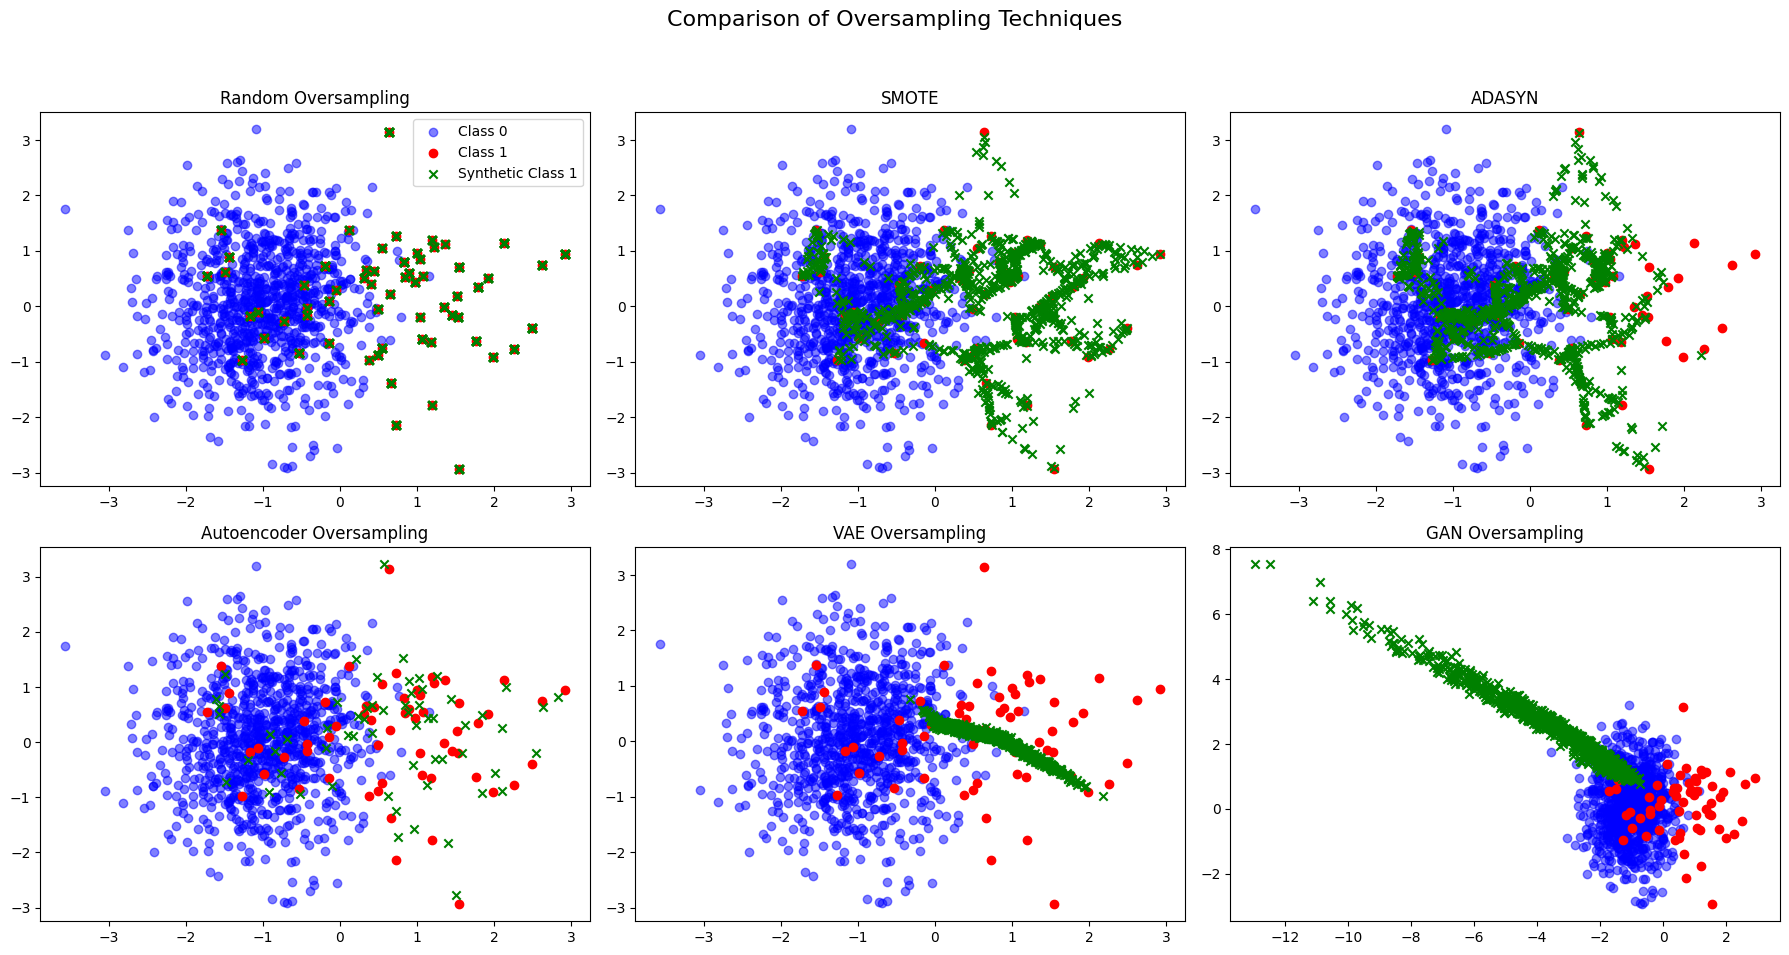

In [18]:
# Now custom subplot visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Row 1 ---
# Random Oversampling
axes[0,0].scatter(X[y==0, 0], X[y==0, 1], c='blue', alpha=0.5, label='Class 0')
axes[0,0].scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1')
mask_new = len(y)
axes[0,0].scatter(X_ros[mask_new:][y_ros[mask_new:]==1,0],
                  X_ros[mask_new:][y_ros[mask_new:]==1,1],
                  c='green', marker='x', label='Synthetic Class 1')
axes[0,0].set_title("Random Oversampling"); axes[0,0].legend()

# SMOTE
axes[0,1].scatter(X[y==0,0], X[y==0,1], c='blue', alpha=0.5)
axes[0,1].scatter(X[y==1,0], X[y==1,1], c='red')
axes[0,1].scatter(X_smote[mask_new:][y_smote[mask_new:]==1,0],
                  X_smote[mask_new:][y_smote[mask_new:]==1,1],
                  c='green', marker='x')
axes[0,1].set_title("SMOTE")

# ADASYN
axes[0,2].scatter(X[y==0,0], X[y==0,1], c='blue', alpha=0.5)
axes[0,2].scatter(X[y==1,0], X[y==1,1], c='red')
axes[0,2].scatter(X_adasyn[mask_new:][y_adasyn[mask_new:]==1,0],
                  X_adasyn[mask_new:][y_adasyn[mask_new:]==1,1],
                  c='green', marker='x')
axes[0,2].set_title("ADASYN")

# --- Row 2 ---
# Autoencoder
axes[1,0].scatter(X[y==0,0], X[y==0,1], c='blue', alpha=0.5)
axes[1,0].scatter(X[y==1,0], X[y==1,1], c='red')
axes[1,0].scatter(X_auto[mask_new:][y_auto[mask_new:]==1,0],
                  X_auto[mask_new:][y_auto[mask_new:]==1,1],
                  c='green', marker='x')
axes[1,0].set_title("Autoencoder Oversampling")

# VAE
axes[1,1].scatter(X[y==0,0], X[y==0,1], c='blue', alpha=0.5)
axes[1,1].scatter(X[y==1,0], X[y==1,1], c='red')
axes[1,1].scatter(X_vae_comb[mask_new:][y_vae_comb[mask_new:]==1,0],
                  X_vae_comb[mask_new:][y_vae_comb[mask_new:]==1,1],
                  c='green', marker='x')
axes[1,1].set_title("VAE Oversampling")

# GAN
axes[1,2].scatter(X[y==0,0], X[y==0,1], c='blue', alpha=0.5)
axes[1,2].scatter(X[y==1,0], X[y==1,1], c='red')
axes[1,2].scatter(X_gan_comb[mask_new:][y_gan_comb[mask_new:]==1,0],
                  X_gan_comb[mask_new:][y_gan_comb[mask_new:]==1,1],
                  c='green', marker='x')
axes[1,2].set_title("GAN Oversampling")

plt.suptitle("Comparison of Oversampling Techniques", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
